In [1]:
import typing as t

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(0)

In [60]:
def generate_true_sequence() -> torch.tensor:
  # generates sequence of 10 number multiple by 5 from [0, 100]
  return torch.randint(0, 20, size=(10,)) * 5

In [89]:
def one_hot_encoder(number: int) -> list[int]:
  one_hot_vector = [0] * 100
  one_hot_vector[number] = 1
  return one_hot_vector

In [98]:
def generate_true_sequence_one_hot(size: int = 1) -> torch.tensor:
  one_hot_vectors = []
  for _ in range(size):
    batch_sequence = generate_true_sequence()
    one_hot_vectors.append([one_hot_encoder(number) for number in batch_sequence])
  return torch.tensor(one_hot_vectors)

In [177]:
def create_discriminator() -> nn.Module:
  # creates discriminator network
  return nn.Sequential(
      nn.Linear(100, 256),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(256, 1),
      nn.Sigmoid()
  )

def create_generator() -> nn.Module:
  # creates generator network
  return nn.Sequential(
      nn.Linear(100, 100)
  )

In [178]:
def select_device() -> str:
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [179]:
# TRAIN DISCRIMINATOR

def train_dis_on_real_batch(
    model: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: t.Callable,
    real_batch: torch.tensor,
    device: str
  ) -> float:

  batch_size = real_batch.shape[0]
  real_samples = real_batch.float().to(device)
  real_samples = real_samples.view(-1, 100)
  opt.zero_grad()

  output = model(real_samples)
  # print('Real samples', real_samples.shape, 'output', output.shape)
  true_labels = torch.ones((batch_size, 10, 1), device=device).view(-1, 1)
  loss = loss_fn(output, true_labels)
  loss.backward()

  loss_value = loss.detach().cpu().item()

  opt.step()
  return loss_value


def train_dis_on_fake_batch(
    model: nn.Module,
    fake_creator: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: t.Callable,
    batch_size: int,
    device: str
) -> float:

  noize = torch.rand((batch_size, 10, 100)).view(-1, 100)
  noize = noize.to(device)
  fake_output = fake_creator(noize)

  opt.zero_grad()

  output = model(fake_output)
  true_labels = torch.zeros((batch_size, 10, 1), device=device).view(-1, 1)
  loss = loss_fn(output, true_labels)
  loss.backward()

  loss_value = loss.detach().cpu().item()

  opt.step()
  return loss_value

In [180]:
# TRAIN GENERATOR

def train_gen(
    model: nn.Module,
    dis: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: t.Callable,
    batch_size: int,
    device: str
) -> float:

  noize = torch.rand((batch_size, 10, 100))
  noize = noize.to(device)
  opt.zero_grad()

  fake_output = model(noize).view(-1, 100)
  dis_detections = dis(fake_output).view(-1, 1)
  true_labels = torch.ones((batch_size, 10, 1), device=device).view(-1, 1)
  loss = loss_fn(dis_detections, true_labels)
  loss.backward()

  loss_value = loss.detach().cpu().item()

  opt.step()
  return loss_value

In [181]:
# USING GENERATOR

def generate(model: nn.Module, batch_size: int, device: str) -> torch.tensor:
  with torch.no_grad():
    noize = torch.rand((batch_size, 10, 100)).view(-1, 100)
    # print(noize.shape)
    noize = noize.to(device)
    gen_output = model(noize)
    gen_output = gen_output.detach().cpu()
  return gen_output

In [182]:
def train_epoch(
    dis: nn.Module,
    gen: nn.Module,
    loader: DataLoader,
    loss_fn: t.Callable,
    dis_opt: torch.optim.Optimizer,
    gen_opt: torch.optim.Optimizer,
    device: str
) -> t.Tuple[float, float]:

  dis_epoch_loss = 0
  gen_epoch_loss = 0

  for batch in loader:
    dis_true_loss = train_dis_on_real_batch(
        model=dis,
        opt=dis_opt,
        loss_fn=loss_fn,
        real_batch=batch,
        device=device
    )
    dis_fake_loss = train_dis_on_fake_batch(
        model=dis,
        fake_creator=gen,
        opt=dis_opt,
        loss_fn=loss_fn,
        batch_size=batch.shape[0],
        device=device
    )
    gen_loss = train_gen(
        model=gen,
        dis=dis,
        opt=gen_opt,
        loss_fn=loss_fn,
        batch_size=batch.shape[0],
        device=device
    )

    dis_epoch_loss += (dis_true_loss + gen_epoch_loss) / 2
    gen_epoch_loss += gen_loss

  dis_epoch_loss = dis_epoch_loss / len(loader)
  gen_epoch_loss = gen_epoch_loss / len(loader)

  return dis_epoch_loss, gen_epoch_loss

In [202]:
BATCH_SIZE = 10
observed_data = generate_true_sequence_one_hot(size=1_000)
loader = DataLoader(observed_data, batch_size=BATCH_SIZE, shuffle=True)

In [203]:
device = select_device()
learning_rate = 0.00005

loss_function = nn.BCELoss().to(device)
gen = create_generator().to(device)
dis = create_discriminator().to(device)

gen_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate)
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=learning_rate)

In [204]:
N_EPOCHS = 35

dis_losses = []
gen_losses = []

for e in range(N_EPOCHS):

  dis_epoch_loss, gen_epoch_loss = train_epoch(
      dis=dis,
      gen=gen,
      loader=loader,
      loss_fn=loss_function,
      dis_opt=dis_optimizer,
      gen_opt=gen_optimizer,
      device=device
  )

  dis_losses.append(dis_epoch_loss)
  gen_losses.append(gen_epoch_loss)

  print('Epoch', e, 'Dis loss', dis_epoch_loss, '\t', 'Gen loss', gen_epoch_loss)
  generated_data = generate(model=gen, batch_size=1, device=device)
  print(generated_data.shape)
  print(generated_data.argmax(dim=-1))
  print('finished epoch', e)

Epoch 0 Dis loss 18.558720416128637 	 Gen loss 0.759133243560791
torch.Size([10, 100])
tensor([71, 71, 71, 22, 71, 71, 71, 71, 71, 71])
finished epoch 0
Epoch 1 Dis loss 20.483225739896298 	 Gen loss 0.8067144000530243
torch.Size([10, 100])
tensor([71, 71, 71, 71, 71, 71, 47, 22, 71, 71])
finished epoch 1
Epoch 2 Dis loss 19.032508605122565 	 Gen loss 0.7493615740537644
torch.Size([10, 100])
tensor([97, 24, 24, 71, 71, 85, 60, 95, 40, 71])
finished epoch 2
Epoch 3 Dis loss 18.974285703599453 	 Gen loss 0.7575679790973663
torch.Size([10, 100])
tensor([35, 65, 70, 70,  5, 70, 97, 35, 87, 70])
finished epoch 3
Epoch 4 Dis loss 18.71216865390539 	 Gen loss 0.7429688173532486
torch.Size([10, 100])
tensor([87, 17, 70, 81, 50, 78, 70, 81, 81, 39])
finished epoch 4
Epoch 5 Dis loss 18.97916727781296 	 Gen loss 0.7550862389802933
torch.Size([10, 100])
tensor([17, 17, 39, 17, 25, 87, 45, 25, 45, 17])
finished epoch 5
Epoch 6 Dis loss 19.106735353469848 	 Gen loss 0.7579658019542694
torch.Size([1

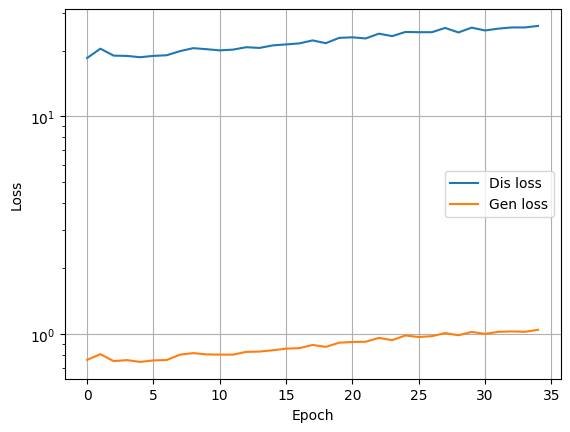

In [205]:
plt.yscale('log')
plt.plot(range(N_EPOCHS), dis_losses, label='Dis loss')
plt.plot(range(N_EPOCHS), gen_losses, label='Gen loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()